<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/3_Redes_Multicapa/1_perceptron_multicapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Perceptron Multicapa

Hasta aquí hemos trabajado con modelos lineales o modelos de una sola capa. Es fácil entender porque estos modelos simples pueden fallar. Por ejemplo, hay fenómenos que pueden tener ciclos o frecuencias asociadas. O pueden existir situaciones donde una de nuestras categorías caiga en un rango acotado de valores (por ejemplo cantidad saludable de azucar en sangre)

Esto nos da a entender que debemos considerar más que solo modelos lineales

### Agregando capas ocultas

![](http://d2l.ai/_images/mlp.svg)

Sin embargo este modelo sigue siendo lineal:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}. \\
    \mathbf{O} & = [\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}]\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b'} + \mathbf{b}^{(2)}\\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b''}
\end{aligned}
$$

Si queremos un modelo más general, debemos usar algo más que solo capas lineales.

Para esto introducimos **funciones de activación**

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$


## Funciones de activacion


In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np

A continuación graficaremos algunas funciones de activación y sus respectivas derivadas

### ReLU

$$\operatorname{ReLU}(x) = \max(0, x)$$


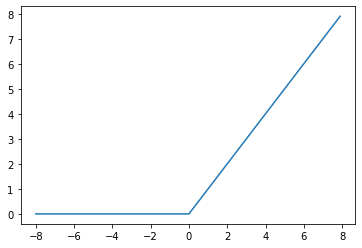

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(), y.detach())

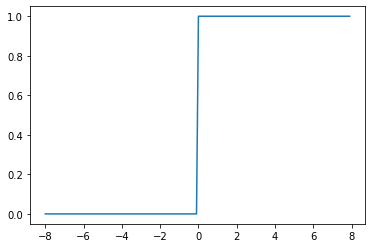

In [3]:
y.backward(torch.ones_like(x), retain_graph=True) # gradiente de y con respecto a x le calcula la derivada 
plt.plot(x.detach(), x.grad)

Existen varias alternativas similares a ReLU, sin embargo, queremos destactar a pReLU. A diferencia de ReLU, pReLU no descarta el gradiente a la izquierda. Además, el peso que se le otorgoa al gradiente a la izquierda es parte de los parámetros del modelo.

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoidea

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

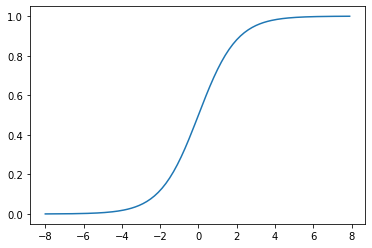

In [4]:
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach())

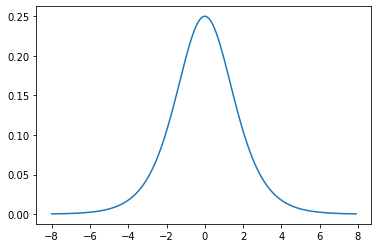

In [5]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

### Tangente hiperbólica

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

$$\operatorname{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}.$$

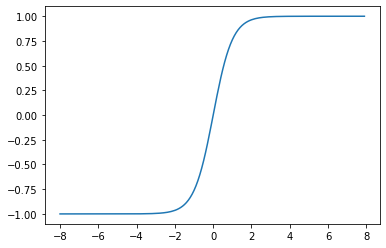

In [6]:
y = torch.tanh(x)
plt.plot(x.detach(), y.detach())

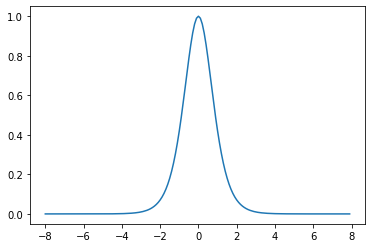

In [7]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

# Implementación de un perceptrón multicapa desde 0



In [8]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

In [9]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [10]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

Como ven, vamos a volver a usar Fashion MNIST

## Inicialización de parametros.


In [11]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## Función de activación


In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## Modelo


In [13]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # '@' multiplicacion de matrices
    return (H@W2 + b2)

## Función de pérdida


In [14]:
loss = nn.CrossEntropyLoss(reduction='none')

Recordemos que vamos a usar de nuevo la exactitud

In [15]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

## Entrenamiento


In [16]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

In [17]:
num_epochs = 10
lr = 0.1
#features, labels = test_iter
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        L += l.sum()
        # Aca el número de ejemplos
        N += l.numel()
        # Aca calcuamos exatitud
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.051804          , train accuracy  0.643833, test accuracy 0.751100
epoch 2, loss 0.599617          , train accuracy  0.801217, test accuracy 0.795800
epoch 3, loss 0.515579          , train accuracy  0.831750, test accuracy 0.798900
epoch 4, loss 0.478816          , train accuracy  0.844233, test accuracy 0.830500
epoch 5, loss 0.452500          , train accuracy  0.853900, test accuracy 0.812800
epoch 6, loss 0.431656          , train accuracy  0.860183, test accuracy 0.831700
epoch 7, loss 0.416313          , train accuracy  0.865983, test accuracy 0.830300
epoch 8, loss 0.402575          , train accuracy  0.870283, test accuracy 0.842100
epoch 9, loss 0.392045          , train accuracy  0.875217, test accuracy 0.837600
epoch 10, loss 0.382438          , train accuracy  0.878167, test accuracy 0.814000


# Implementacion concisa


In [18]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

## Modelo


In [19]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [20]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [21]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [22]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [23]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [25]:
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 0.372684          , train accuracy  0.879550, test accuracy 0.847700
epoch 2, loss 0.365238          , train accuracy  0.883150, test accuracy 0.839100
epoch 3, loss 0.357514          , train accuracy  0.885717, test accuracy 0.854100
epoch 4, loss 0.351156          , train accuracy  0.887650, test accuracy 0.851300
epoch 5, loss 0.344470          , train accuracy  0.889233, test accuracy 0.857500
epoch 6, loss 0.339516          , train accuracy  0.891233, test accuracy 0.852600
epoch 7, loss 0.335224          , train accuracy  0.894917, test accuracy 0.848100
epoch 8, loss 0.329821          , train accuracy  0.896000, test accuracy 0.849300
epoch 9, loss 0.324969          , train accuracy  0.898400, test accuracy 0.865700
epoch 10, loss 0.319469          , train accuracy  0.898683, test accuracy 0.858800
